# #1: create an environment and select the kernel
Here are the command I use for creating an env:

`conda create --name MotorSavings python=3.10`

Once you done that make sure that your notebook is connected to your env. You may need to close and reopen your program.
# Install all required packages
`pip install -r ../requirements.txt`

In [8]:
!pip install -r ../requirements.txt

# 1- Train the models

In [1]:
import os
import sys 
sys.path.append(os.path.abspath('..'))
from get_utils import return_ignore, get_loss
from plot import *
import matplotlib.pyplot as plt
from utils import get_initial_loss, get_rate
import pandas as pd
import seaborn as sb


#%matplotlib qt
#%matplotlib widget
%matplotlib inline

# Directory info
This is the format that I use for generating directory when I train models. I use the network size of 128 for all analysis.

In [2]:
folder_name = 'Sim_fixed_128'
n_model = 40 # number of simulated networks
sizes = [16,32,64,128,256]

root_dir = '/Volumes/T9/MotorNet'

base_dir = root_dir
save_fig = os.path.join(os.path.expanduser('~'),'Dropbox/Projects/papers/MotorSavings/paper/figures_raw')

# Running all models for all phases of training and for different network sizes
This could take almost one day, depending on your system. 
### Skip this if you already have your networks  

In [3]:
# for n_s in sizes: # sizes
#     network_siz = n_s
#     !python ../model.py {1} {network_siz} {n_model} {0} {1}

# #1: Learing curves for all phases

In [4]:
ignore = return_ignore(folder_name,n_model) # sometimes some of cpus fail so we want to ignore those models
loss = get_loss(folder_name,n_model,w=1,target=None,ignore=ignore)

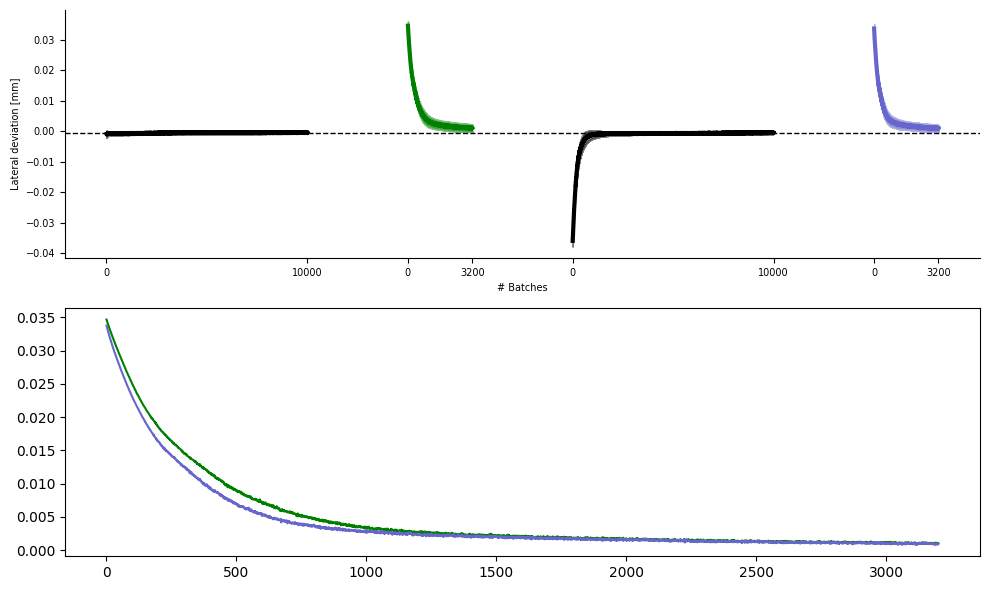

In [6]:
# Plot learning
fig, ax = plot_learning(loss,figsize=(10,6),show_saving=True,gap=5000) # (3.8,2.2)
plt.tight_layout()
plt.show()
#fig.savefig(os.path.join(save_fig,'learning_curve2.pdf'),dpi=300,bbox_inches='tight')

# #2: Do we have savings? 
Get the initial values of the loss and also the learning rate. It saves the result as a dataframe so that we don't need to run it every time.

In [7]:
# Create the dataframe
D = pd.DataFrame()

for n_s in sizes:
    network_siz = n_s
    fn = f'Sim_fixed_{network_siz}'

    ignore = return_ignore(fn,n_model)
    loss = get_loss(fn,n_model,w=1,target=None,ignore=ignore)

    R = get_rate(loss,w=5,check_fit=False)
    I = get_initial_loss(loss)

    R['size'] = network_siz
    I['size'] = network_siz

    T = pd.concat([R,I], ignore_index=True)

    D = pd.concat([D,T], ignore_index=True)

D.to_csv(base_dir+'/model_loss.csv',index=False)

# Plot the result only for network of size 128

In [29]:

# Define bootstrap function
def bootstrap_paired_test(a, b, n_bootstrap=10000):
    """Perform a bootstrap test for paired samples."""
    diffs = a - b  # Compute pairwise differences
    observed_mean = np.median(diffs)  # Observed mean difference

    # Bootstrap resampling: Shuffle sign of differences
    boot_medians = np.array([np.median(diffs * np.random.choice([-1, 1], size=len(diffs))) for _ in range(n_bootstrap)])

    # Compute p-value: Two-tailed test
    p_value = np.mean(np.abs(boot_medians) >= np.abs(observed_mean))
    
    return observed_mean, p_value

# Perform bootstrap paired test
obs_diff, p_value = bootstrap_paired_test(a, b)

# Display results
print(f'Observed Difference: {obs_diff}, p-value: {p_value}')

Observed Difference: 0.00012300712296570002, p-value: 0.0281


In [ ]:
from scipy.stats import ttest_rel

a = T[T['phase']=='NF1']['value'].values
b = T[T['phase']=='NF2']['value'].values

t_stat, p_value = ttest_rel(a, b, nan_policy='omit')
print(f't-statistic: {t_stat}, p-value: {p_value}')

t-statistic: 2.218725422487076, p-value: 0.032394595492936724


(array([2., 3., 3., 6., 8., 8., 4., 5., 0., 1.]),
 array([-6.04536006e-04, -4.52820461e-04, -3.01104916e-04, -1.49389372e-04,
         2.32617313e-06,  1.54041718e-04,  3.05757263e-04,  4.57472807e-04,
         6.09188352e-04,  7.60903897e-04,  9.12619442e-04]),
 <BarContainer object of 10 artists>)

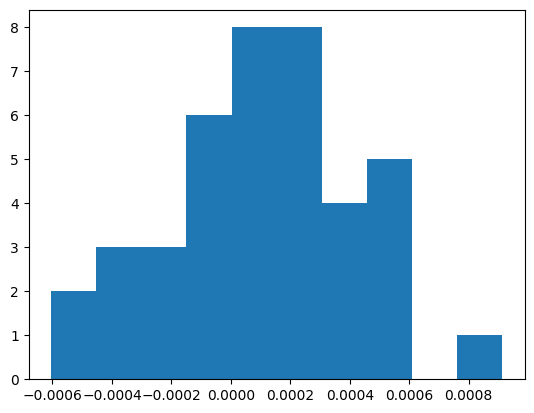

In [30]:
plt.hist(a-b)

In [27]:
np.mean(b-a)*1000

-0.1106694851841855

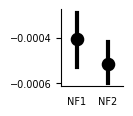

In [17]:
# Generate the plots
D = pd.read_csv(base_dir+'/model_loss.csv')
feature = 'init' # you can select 'init' or 'rate'

filter_condition = (
    (D['phase'].isin(['NF1', 'NF2'])) &
    (D['size'] == 128) &
    (D['feature'] == feature) # you can select 'init' or 'rate'
)
T = D[filter_condition].reset_index(drop=True)


# plot 
ax = my_pointplot(T,x='phase',y='value',hue='phase',linewidth=3,ax=None)
fig=ax.get_figure()
# if feature == 'rate':
#     fig.savefig(os.path.join(save_fig, 'saving_rate.pdf'), dpi=300, bbox_inches='tight')
# else:
#     fig.savefig(os.path.join(save_fig, 'saving_init.pdf'), dpi=300, bbox_inches='tight')

# Plot the result only for networks of all sizes

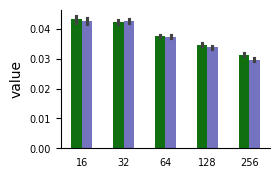

In [9]:
D = pd.read_csv(base_dir+'/model_loss.csv')
feature = 'init' # you can select 'init' or 'rate'

filter_condition = (
    (D['phase'].isin(['FF1', 'FF2'])) &
    (D['feature'] == feature) # you can select 'init' or 'rate'
)
T = D[filter_condition].reset_index(drop=True)


# plot
fig,ax = my_barplot(T,x='size',y='value',hue='phase')
#fig.savefig(os.path.join(save_fig, 'perf_vs_size.pdf'), dpi=300, bbox_inches='tight')

# % of network that showed saving vs. network size

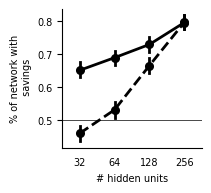

In [10]:
D = pd.read_csv(base_dir+'/model_loss.csv')
fig = None
ax = None

linestyle=['-','--']

for i,feature in enumerate(['rate','init']):
#feature = 'init' # you can select 'init' or 'rate'

    filter_condition = (
        (D['phase'].isin(['FF1','FF2'])) &
        (D['feature'] == feature) &
        (D['size'] <512)  &
        (D['size'] > 16)
    )
    T = D[filter_condition].reset_index(drop=True)

    ff1_data = T[T['phase']=='FF1']
    ff2_data = T[T['phase']=='FF2']
    merged_data = pd.merge(ff1_data,ff2_data,on='size',suffixes=('_ff1', '_ff2'))
    # Calculate the difference in 'loss'
    if feature == 'init':
        merged_data['loss_difference'] = (-merged_data['value_ff2']+merged_data['value_ff1']>0 ) # <0 
    else:
        merged_data['loss_difference'] = (merged_data['value_ff2']-merged_data['value_ff1']>0) # >0

    # Plotting
    ax = my_pointplot(merged_data,x='size',y='loss_difference',hue=None,figsize=(1.8, 1.8),ax=ax,linewidth=2,color='black',linestyle=linestyle[i],xlabel='# hidden units',ylabel='% of network with\n savings')

ax.axhline(0.5, color='black', linestyle='-', label='Chance level',linewidth=0.5)

fig=ax.get_figure()
# fig.savefig(os.path.join(save_fig,'saving_vs_size.pdf'),dpi=300,bbox_inches='tight')